# Create dataset

In [1]:
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000
x,y = make_circles(n_samples, noise = 0.03, random_state = 1)

# Visualize dataset

In [3]:
import pandas as pd

In [4]:
circles = pd.DataFrame({
    "x1": x[:, 0],
    "x2": x[:, 1],
    "label": y
})

In [5]:
circles.head(10)

,x1,x2,label
0,0.836198,0.035631,1
1,-0.530598,-0.648715,1
2,0.853869,-0.611566,0
3,-0.092147,-0.965144,0
4,-1.001623,0.144467,0
5,0.476053,-0.611694,1
6,-0.963053,-0.154417,0
7,-0.541585,-0.531194,1
8,-0.705709,-0.635493,0
9,0.835799,0.580793,0


In [6]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

# Plot dataset

In [7]:
import matplotlib.pyplot as plt

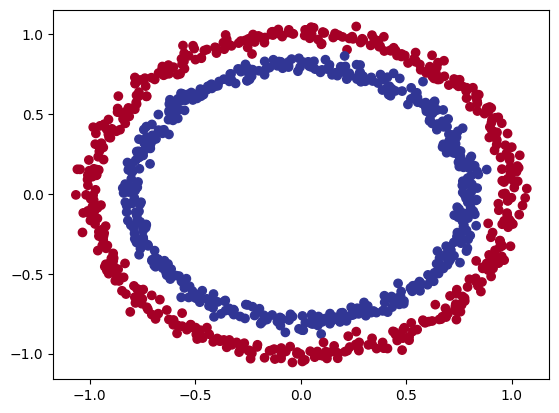

In [8]:
plt.scatter(
    x=x[:,0],
    y=x[:,1],
    c=y,
    cmap=plt.cm.RdYlBu
)

This is a toy dataset <br>
It doesn't contain real data, but emulate it to propose a challenging problem useful to test machine learning algorithms

In [9]:
print(x[0], x.shape)
print(y[0], y.shape)

[0.83619806 0.03563148] (1000, 2)
1 (1000,)


# Prepare data to use in pytorch

In [10]:
import torch

In [11]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
print(x[0], x.shape)
print(y[0], y.shape)

tensor([0.8362, 0.0356]) torch.Size([1000, 2])
tensor(1.) torch.Size([1000])


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
xt, xv, yt, yv = train_test_split(
    x,
    y,
    test_size = 0.2,
    random_state=0
)
print(len(xt),len(yt),len(xv),len(yv))

800 800 200 200


# Set up device agnostic code

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# Build model from nn.Module

In [16]:
from torch import nn

In [17]:
class PredictCircleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 2, out_features = 5)
        self.layer2 = nn.Linear(in_features = 5, out_features = 1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

In [18]:
model = PredictCircleModule().to(device)
print(model)

PredictCircleModule(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)


In [19]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.4854, -0.3896],
         [ 0.0249,  0.4761],
         [ 0.2252, -0.6584],
         [-0.2849, -0.5850],
         [ 0.4825, -0.6299]], requires_grad=True),
 Parameter containing:
 tensor([ 0.4442,  0.1386, -0.0111,  0.2979, -0.0155], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0161, -0.1993,  0.3486,  0.0554,  0.1268]], requires_grad=True),
 Parameter containing:
 tensor([-0.3493], requires_grad=True)]

In [20]:
yp = model(xt.to(device))
print(yp.shape, yt.shape)
print(yp[:5], yt[:5])

torch.Size([800, 1]) torch.Size([800])
tensor([[-0.7079],
        [-0.2656],
        [ 0.0091],
        [-0.4420],
        [-0.6818]], grad_fn=<SliceBackward0>) tensor([1., 1., 1., 0., 1.])


# Define loss function, optimizer, and evaluation metric

In [21]:
loss = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(
    params = model.parameters(),
    lr = 0.1
)

In [22]:
def accuracy(yp, y):
    correct = torch.eq(y, yp).sum().item()
    return (correct / len(yp)) * 100

## Observation about logits

In [23]:
logits = model(xt.to(device))
print(logits[:5])

tensor([[-0.7079],
        [-0.2656],
        [ 0.0091],
        [-0.4420],
        [-0.6818]], grad_fn=<SliceBackward0>)


In [24]:
yp = torch.sigmoid(logits)
print(yp[:5])

tensor([[0.3301],
        [0.4340],
        [0.5023],
        [0.3913],
        [0.3359]], grad_fn=<SliceBackward0>)


In [25]:
yp = torch.round(torch.sigmoid(logits))
print(yp[:5])

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.]], grad_fn=<SliceBackward0>)


In [26]:
print(yp.squeeze()[:5])
print(yv[:5])

tensor([0., 0., 1., 0., 0.], grad_fn=<SliceBackward0>)
tensor([1., 1., 0., 1., 1.])


# Create training loop

## Step by step

### Forward pass
Pass an input, compute the forward function, store the results

In [27]:
model.train()
logits = model(xt.to(device)).squeeze()
yp = torch.round(torch.sigmoid(logits))

### Calculate the cost
Compare the results to the truth-table and calculate the cost

In [28]:
cost = loss(logits, yt)

### Reset gradients
Since pytorch natively aggregates gradients, you must reset them for your use case

In [29]:
optim.zero_grad()

### Backpropagate the loss
Use the computed loss to calculate the gradient of each parameter

In [30]:
cost.backward()

### Improve the parameters
Use the computed gradients to update the parameters

In [31]:
optim.step()

### Measure accuracy
Evaluate how the updated model is performing

In [32]:
model.eval()
with torch.inference_mode():
    logits = model(xv).squeeze()
    yp = torch.round(torch.sigmoid(logits))
    cost = loss(logits, yv)
    acc = accuracy(yp, yv)
print(f"Loss: {cost:.5f} | Accuracy: {acc:.2f}")

Loss: 0.71442 | Accuracy: 43.00


## Complete

In [33]:
epochs = 100
costs = []
accuracies = []

for epoch in range(epochs):
    model.train()
    # forward pass
    logits = model(xt.to(device)).squeeze()
    yp = torch.round(torch.sigmoid(logits))
    # calculate the cost
    cost = loss(logits, yt)
    # reset gradients
    optim.zero_grad()
    # backpropagate the loss
    cost.backward()
    # improve the parameters
    optim.step()
    # measure accuracy
    model.eval()
    with torch.inference_mode():
        logits = model(xv).squeeze()
        yp = torch.round(torch.sigmoid(logits))
        cost = loss(yp, yv)
        acc = accuracy(yp, yv)
        if epoch % 10 == 0:
            costs.append(cost)
            accuracies.append(acc)
            print(f"Epoch: {epoch} | Loss: {cost:.5f} | Accuracy: {acc:.2f}")
        

Epoch: 0 | Loss: 0.74237 | Accuracy: 44.00
Epoch: 10 | Loss: 0.73387 | Accuracy: 47.50
Epoch: 20 | Loss: 0.72918 | Accuracy: 50.00
Epoch: 30 | Loss: 0.73158 | Accuracy: 50.00
Epoch: 40 | Loss: 0.74209 | Accuracy: 48.50
Epoch: 50 | Loss: 0.74329 | Accuracy: 48.50
Epoch: 60 | Loss: 0.75069 | Accuracy: 47.50
Epoch: 70 | Loss: 0.74999 | Accuracy: 48.00
Epoch: 80 | Loss: 0.75119 | Accuracy: 48.00
Epoch: 90 | Loss: 0.74429 | Accuracy: 49.50


## Warning
I commited a mistake. The cost could not be backpropagated due to a rounding function being applied. The rounding function makes the whole calculation non-linear.

```python
# wrong
logits = model(xt.to(device)).squeeze()
yp = torch.round(torch.sigmoid(logits))
cost = loss(yp, yt)

# right
logits = model(xt.to(device)).squeeze()
yp = torch.round(torch.sigmoid(logits))
cost = loss(logits, yt)
```

## Plotting decision boundary

In [34]:
import numpy as np

In [35]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

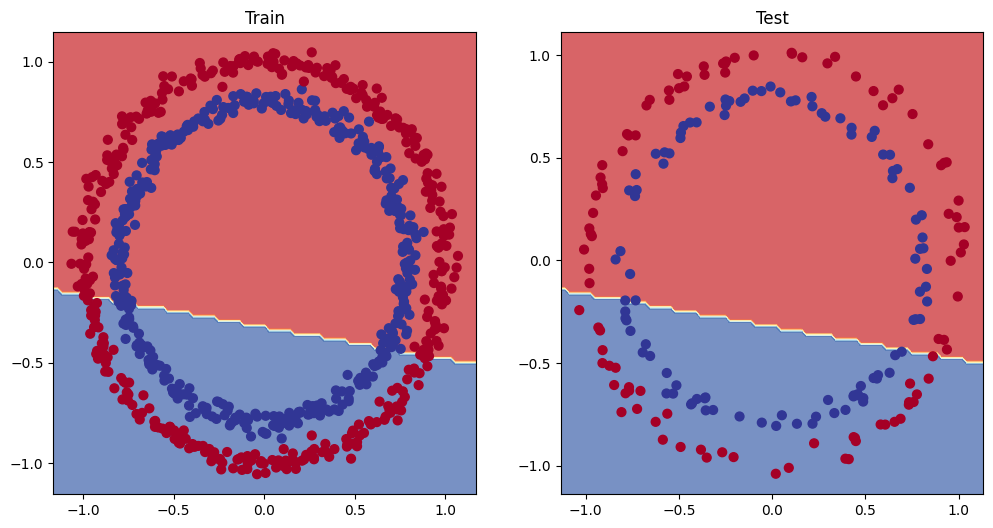

In [36]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, xt, yt)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, xv, yv)

# Experimenting with different hyperparameters

In [37]:
class PredictCircleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer3 = nn.Linear(in_features = 10, out_features = 1)

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

In [38]:
model = PredictCircleModule().to(device)

In [39]:
loss = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(
    params = model.parameters(),
    lr = 0.1
)
def accuracy(yp, y):
    correct = torch.eq(y, yp).sum().item()
    return (correct / len(yp)) * 100

In [40]:
epochs = 1000
costs = []
accuracies = []

for epoch in range(epochs):
    model.train()
    # forward pass
    logits = model(xt.to(device)).squeeze()
    yp = torch.round(torch.sigmoid(logits))
    # calculate the cost
    cost = loss(logits, yt)
    # reset gradients
    optim.zero_grad()
    # backpropagate the loss
    cost.backward()
    # improve the parameters
    optim.step()
    # measure accuracy
    model.eval()
    with torch.inference_mode():
        logits = model(xv).squeeze()
        yp = torch.round(torch.sigmoid(logits))
        cost = loss(yp, yv)
        acc = accuracy(yp, yv)
        if epoch % 10 == 0:
            costs.append(cost)
            accuracies.append(acc)
            print(f"Epoch: {epoch} | Loss: {cost:.5f} | Accuracy: {acc:.2f}")

Epoch: 0 | Loss: 0.78226 | Accuracy: 55.00
Epoch: 10 | Loss: 0.77443 | Accuracy: 52.00
Epoch: 20 | Loss: 0.75932 | Accuracy: 52.50
Epoch: 30 | Loss: 0.75231 | Accuracy: 51.50
Epoch: 40 | Loss: 0.74630 | Accuracy: 51.50
Epoch: 50 | Loss: 0.73770 | Accuracy: 52.50
Epoch: 60 | Loss: 0.74150 | Accuracy: 51.50
Epoch: 70 | Loss: 0.73530 | Accuracy: 52.50
Epoch: 80 | Loss: 0.73910 | Accuracy: 51.50
Epoch: 90 | Loss: 0.73720 | Accuracy: 52.00
Epoch: 100 | Loss: 0.74600 | Accuracy: 50.00
Epoch: 110 | Loss: 0.74600 | Accuracy: 50.00
Epoch: 120 | Loss: 0.75220 | Accuracy: 49.00
Epoch: 130 | Loss: 0.74790 | Accuracy: 49.50
Epoch: 140 | Loss: 0.75480 | Accuracy: 48.00
Epoch: 150 | Loss: 0.75410 | Accuracy: 48.50
Epoch: 160 | Loss: 0.74980 | Accuracy: 49.00
Epoch: 170 | Loss: 0.75530 | Accuracy: 48.50
Epoch: 180 | Loss: 0.76460 | Accuracy: 47.00
Epoch: 190 | Loss: 0.77080 | Accuracy: 46.00
Epoch: 200 | Loss: 0.76890 | Accuracy: 46.50
Epoch: 210 | Loss: 0.77320 | Accuracy: 46.00
Epoch: 220 | Loss: 0.

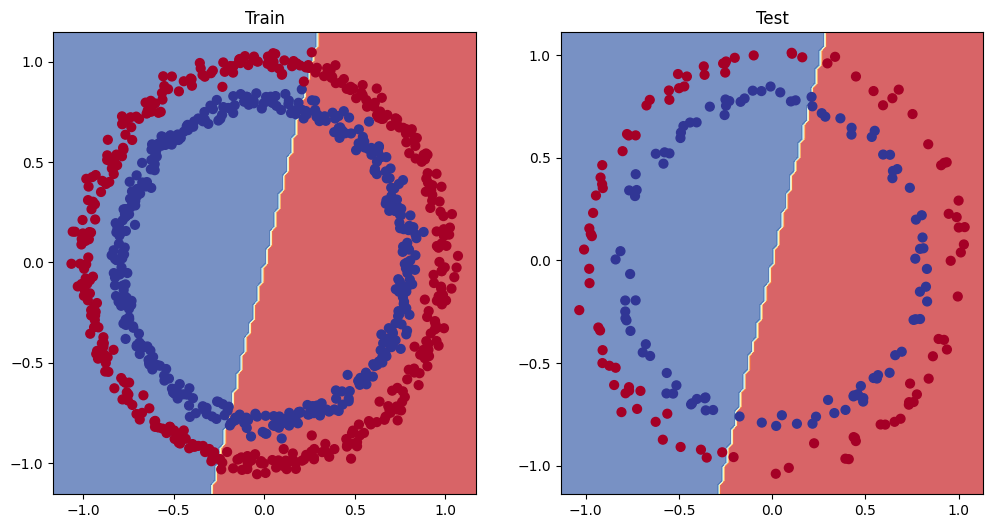

In [41]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, xt, yt)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, xv, yv)

In [42]:
class PredictCircleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer3 = nn.Linear(in_features = 10, out_features = 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

In [43]:
model = PredictCircleModule().to(device)

In [44]:
loss = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(
    params = model.parameters(),
    lr = 0.1
)
def accuracy(yp, y):
    correct = torch.eq(y, yp).sum().item()
    return (correct / len(yp)) * 100

In [45]:
epochs = 1000
costs = []
accuracies = []

for epoch in range(epochs):
    model.train()
    # forward pass
    logits = model(xt.to(device)).squeeze()
    yp = torch.round(torch.sigmoid(logits))
    # calculate the cost
    cost = loss(logits, yt)
    # reset gradients
    optim.zero_grad()
    # backpropagate the loss
    cost.backward()
    # improve the parameters
    optim.step()
    # measure accuracy
    model.eval()
    with torch.inference_mode():
        logits = model(xv).squeeze()
        yp = torch.round(torch.sigmoid(logits))
        cost = loss(yp, yv)
        acc = accuracy(yp, yv)
        if epoch % 10 == 0:
            costs.append(cost)
            accuracies.append(acc)
            print(f"Epoch: {epoch} | Loss: {cost:.5f} | Accuracy: {acc:.2f}")

Epoch: 0 | Loss: 0.69315 | Accuracy: 50.00
Epoch: 10 | Loss: 0.69315 | Accuracy: 50.00
Epoch: 20 | Loss: 0.69315 | Accuracy: 50.00
Epoch: 30 | Loss: 0.69315 | Accuracy: 50.00
Epoch: 40 | Loss: 0.69315 | Accuracy: 50.00
Epoch: 50 | Loss: 0.69315 | Accuracy: 50.00
Epoch: 60 | Loss: 0.69315 | Accuracy: 50.00
Epoch: 70 | Loss: 0.69315 | Accuracy: 50.00
Epoch: 80 | Loss: 0.69315 | Accuracy: 50.00
Epoch: 90 | Loss: 0.69315 | Accuracy: 50.00
Epoch: 100 | Loss: 0.69625 | Accuracy: 49.50
Epoch: 110 | Loss: 0.70245 | Accuracy: 48.50
Epoch: 120 | Loss: 0.72415 | Accuracy: 45.00
Epoch: 130 | Loss: 0.75066 | Accuracy: 41.50
Epoch: 140 | Loss: 0.74837 | Accuracy: 44.00
Epoch: 150 | Loss: 0.76318 | Accuracy: 42.00
Epoch: 160 | Loss: 0.77918 | Accuracy: 40.00
Epoch: 170 | Loss: 0.78089 | Accuracy: 40.50
Epoch: 180 | Loss: 0.78569 | Accuracy: 40.50
Epoch: 190 | Loss: 0.78170 | Accuracy: 42.50
Epoch: 200 | Loss: 0.77720 | Accuracy: 44.00
Epoch: 210 | Loss: 0.77840 | Accuracy: 44.00
Epoch: 220 | Loss: 0.

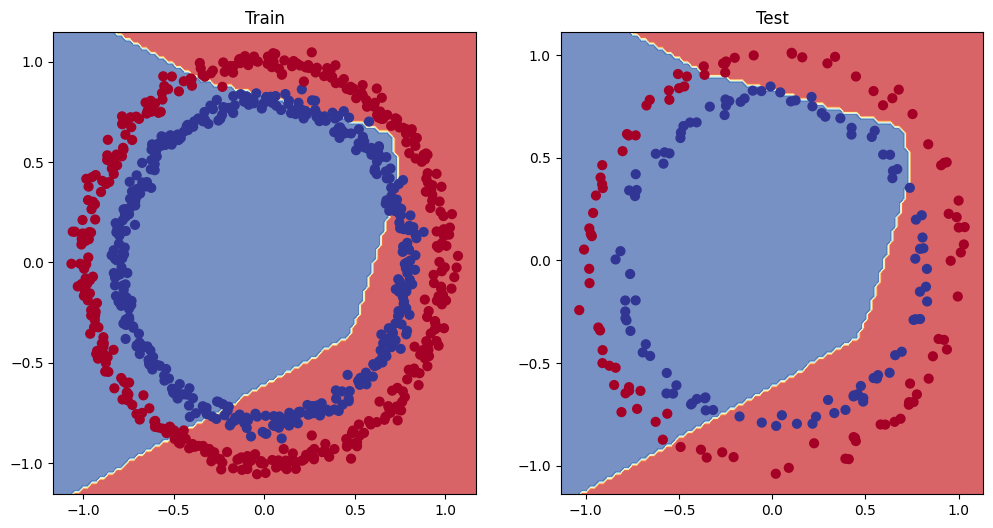

In [46]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, xt, yt)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, xv, yv)

# Multiclass classification

## Create data

### 1. Create some multi-class data with make_blobs()

In [47]:
from sklearn.datasets import make_blobs

In [48]:
x,y = make_blobs(
    n_samples = 1000,
    n_features = 2,
    centers = 4,
    cluster_std = 1.5,
    random_state = 42
)

### 2. Turn the data into tensors (the default of make_blobs() is to use NumPy arrays) 

In [49]:
import torch

In [50]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

### 3. Split the data into training and test sets using train_test_split()

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
xt, xv, yt, yv = train_test_split(
    x,
    y,
    test_size = 0.2,
    random_state = 0
)

### 4. Visualize the data 

In [53]:
print(x[:5])
print(y[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]])
tensor([3, 2, 2, 1, 1])


In [54]:
import matplotlib.pyplot as plt

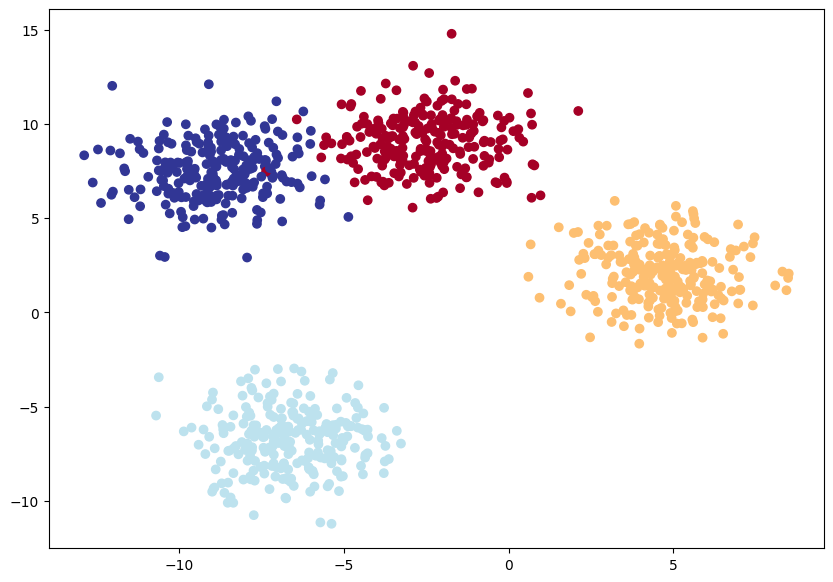

In [55]:
plt.figure(figsize=(10, 7))
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdYlBu)

## Build the model

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [57]:
class BlobModule(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = output_features)
        )
    def forward(self, x):
        return self.network(x)

model = BlobModule(
    input_features = 2,
    output_features = 4,
    hidden_units = 8
).to(device)
print(model)

BlobModule(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [58]:
loss = nn.CrossEntropyLoss()
optim = torch.optim.SGD(
    model.parameters(),
    lr = 0.1
)
def accuracy(yp, y):
    correct = torch.eq(y, yp).sum().item()
    return (correct / len(yp)) * 100

In [59]:
print(model(x)[:5])
print(model(x)[0].shape)

tensor([[ 1.1534e+00,  7.1492e-01,  2.2300e+00, -1.3058e+00],
        [-3.2126e-01, -1.1776e-03, -2.2951e-01, -6.6326e-01],
        [-3.2603e-01, -1.5313e-03, -2.3403e-01, -6.9317e-01],
        [-5.8193e-01, -1.9166e-01, -7.7626e-01,  4.9133e-01],
        [-6.9998e-01, -2.4959e-01, -9.7421e-01,  5.5264e-01]],
       grad_fn=<SliceBackward0>)
torch.Size([4])


### Turn logits into probability

In [60]:
logits = model(x.to(device))
yp = torch.softmax(logits, dim=1)
print(logits[0])
print(yp[0])

tensor([ 1.1534,  0.7149,  2.2300, -1.3058], grad_fn=<SelectBackward0>)
tensor([0.2144, 0.1383, 0.6291, 0.0183], grad_fn=<SelectBackward0>)


In [61]:
print(yp[0].sum())
print(yp[0].argmax())

tensor(1., grad_fn=<SumBackward0>)
tensor(2)


## Train the model

In [62]:
epochs = 100
costs = []
accuracies = []

xt, yt = xt.to(device), yt.to(device)
xv, yv = xv.to(device), yv.to(device)

for epoch in range(epochs):
    model.train()
    logits = model(xt)
    yp = torch.softmax(logits, dim=1).argmax(dim=1)
    cost = loss(logits, yt)
    optim.zero_grad()
    cost.backward()
    optim.step()
    model.eval()
    with torch.inference_mode():
        logits = model(xv)
        yp = torch.softmax(logits, dim=1).argmax(dim=1)
        cost = loss(logits, yv)
        acc = accuracy(yp, yv)
        if epoch % 10 == 0:
            costs.append(cost)
            accuracies.append(acc)
            print(f"Epoch: {epoch} | Loss: {cost:.5f} | Accuracy: {acc:.2f}")

Epoch: 0 | Loss: 0.94785 | Accuracy: 67.00
Epoch: 10 | Loss: 0.23330 | Accuracy: 92.00
Epoch: 20 | Loss: 0.09137 | Accuracy: 99.00
Epoch: 30 | Loss: 0.06565 | Accuracy: 99.00
Epoch: 40 | Loss: 0.05484 | Accuracy: 99.00
Epoch: 50 | Loss: 0.04945 | Accuracy: 99.00
Epoch: 60 | Loss: 0.04649 | Accuracy: 99.00
Epoch: 70 | Loss: 0.04479 | Accuracy: 99.00
Epoch: 80 | Loss: 0.04381 | Accuracy: 99.00
Epoch: 90 | Loss: 0.04327 | Accuracy: 99.00


## Visualize the decision boundary

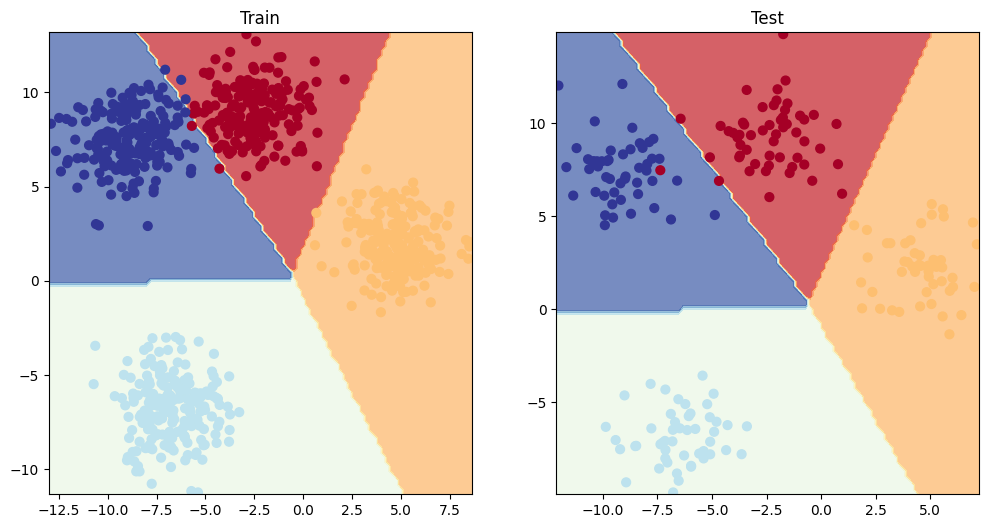

In [63]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, xt, yt)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, xv, yv)

## Other metrics

In [64]:
try:
    from torchmetrics import Accuracy
except:
    !py -m pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)
print(torchmetrics_accuracy(yp, yv))

tensor(0.9900)
